## MQB7046 MODELLING PUBLIC HEALTH DATA - Ordinal logistic regression
Prepared by Claire Choo (15/4/2024)

Ordinal Logistic Regression is a statistical model used when the dependent variable is ordinal in nature, that is it has a clear ordering or ranking, but the differences between the categories may not be equal. 
The dependent variable must be ordinal, such as a rating scale (e.g. 1 = poor, 2 = fair, 3 = good, 4 = excellent). 
The model assumes that the relationship between the predictor variables and the logit of the cumulative probabilities is the same for all logits (the proportional odds assumption). 

#### Practical 5

A study examined factors that influence the decision of whether to apply to graduate programme.  Undergraduates were asked if they are unlikely, somewhat likely, or very likely to apply to graduate programme. The outcome variable has three categories coded as 0,1,2. Data on parental educational status (0 is no tertiary education, 1 is with tertiary education), whether the undergraduate institution is public (1) or private (0), and current GPA was collected. 

In [1]:
import sys
import os
sys.path.append(os.path.dirname(os.getcwd()))

import pandas as pd
import wh0102 as mphd

data_dictionary = {
    "apply":{0:"unlikely",
             1:"somewhat_likely",
             2:"very_likely"},
    "pared":{0:"no_tertiary_education",
             1:"with_tertiary_education"},
    "public":{0:"private",
              1:"public"}
}

# Load the dataset into a DataFrame
grad = pd.read_csv("grad.csv")

# Display the first few rows of the DataFrame to verify that the data is loaded correctly
grad.head()

,pared,public,gpa,apply
0,0,0,3.26,2
1,1,0,3.21,1
2,1,1,3.94,0
3,0,0,2.81,1
4,0,0,2.53,1


/var/folders/kx/mhdv49d913j0rf2b8xmgtmhw0000gn/T/ipykernel_31048/3111779272.py:6: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  df.loc[:,"apply"] = pd.Categorical(df.loc[:,"apply"], categories=list(data_dictionary["apply"].values()), ordered = True)


+-----------------+-------+
|                 |  gpa  |
+-----------------+-------+
|      count      | 400.0 |
|      mean       |  3.0  |
|       std       |  0.4  |
|       min       |  1.9  |
|       25%       | 2.72  |
|       50%       | 2.99  |
|       75%       | 3.27  |
|       max       |  4.0  |
|      skew       | -0.03 |
|    kurtosis     | -0.41 |
|     shapiro     |  1.0  |
| shapiro_p_value | 0.47  |
+-----------------+-------+
QQ plot for gpa


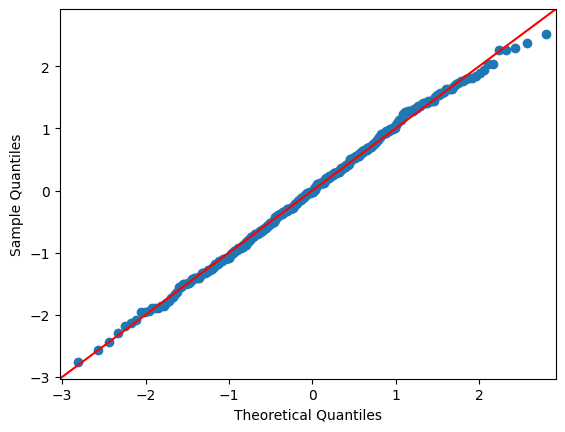

In [2]:
# To convert to string type of dataframe
df = mphd.categorical_data.reverse_encode(grad, json_dict=data_dictionary)

# Categorize the apply
grad.loc[:,"apply"] = pd.Categorical(grad.loc[:,"apply"], categories=list(range(0,3)), ordered = True)
df.loc[:,"apply"] = pd.Categorical(df.loc[:,"apply"], categories=list(data_dictionary["apply"].values()), ordered = True)

# Perform descriptive analysis on continous data
descriptive_df = mphd.continous_data.descriptive_analysis(df)

In [3]:
# Perform the descriptive statistics 
# Conduct hypothesis testing
chi2_positive_df, chi2_negative_df = mphd.categorical_data.categorical_descriptive_analysis(df, 
                                                                                            independent_variables = ["pared", "public"], 
                                                                                            dependent_variables = "apply")

Descriptive Analysis for independent variables:
Descriptive Analysis on pared
+-------------------------+----------+-----------------+-------------+-------+------------+
|          pared          | unlikely | somewhat_likely | very_likely |  All  | percentage |
+-------------------------+----------+-----------------+-------------+-------+------------+
|  no_tertiary_education  |  200.0   |      110.0      |    27.0     | 337.0 |   84.25    |
| with_tertiary_education |   20.0   |      30.0       |    13.0     | 63.0  |   15.75    |
|           All           |  220.0   |      140.0      |    40.0     | 400.0 |   100.0    |
+-------------------------+----------+-----------------+-------------+-------+------------+
Chi2 test between pared and apply have chi2 statistics value = 19.21 and p_value of 0.00
----------------------------------------------------------------
Descriptive Analysis on public
+---------+----------+-----------------+-------------+-------+------------+
| public  | unlik

In [4]:
# Generate independent variation list and formula
independent_variable_list = mphd.regression.iterate_independent_variables(independent_variables = grad.columns[0:3],
                                                                          dependent_variables = grad.columns[3])
independent_variable_columns_variation = independent_variable_list[0]

# run ordinal logistic regression with multiple predictors ('pared', 'public', 'gpa')
model_list = [mphd.regression.multinominal_logistic_regression(grad, x = independent_variable, y = grad.columns[3])
              for independent_variable in independent_variable_columns_variation]

# Generate summary for all independent that fitted into the model
print(model_list[-1].summary())

                          MNLogit Regression Results                          
Dep. Variable:                  apply   No. Observations:                  400
Model:                        MNLogit   Df Residuals:                      392
Method:                           MLE   Df Model:                            6
Date:                Sun, 21 Apr 2024   Pseudo R-squ.:                 0.03671
Time:                        00:10:06   Log-Likelihood:                -357.00
converged:                       True   LL-Null:                       -370.60
Covariance Type:            nonrobust   LLR p-value:                 0.0001322
   apply=1       coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -1.8790      0.864     -2.175      0.030      -3.572      -0.186
pared          0.9516      0.317      3.001      0.003       0.330       1.573
public        -0.4188      0.343     -1.220      0.2

In [6]:
# Generate odds ratio (95%CI)
model_list[-1].conf_int()

lower     upper
apply                           
1     const  -3.571949 -0.185971
      pared   0.330216  1.573078
      public -1.091663  0.254026
      gpa    -0.120042  1.017544
2     const  -7.687800 -2.007735
      pared   0.546720  2.201586
      public -0.509115  1.229240
      gpa    -0.005320  1.853399

In [ ]:
# Generate predicted probabilities for each observation
import numpy as np
pred_choice = model_list[-1].model.predict(model_list[-1].params, exog=grad[['pared', 'public', 'gpa']]).argmax(1)
print((np.asarray(grad.loc[:,"apply"].values) == pred_choice).mean())

In [ ]:
# Calculate cumulative probabilities
model_list[-1].cdf(x)

In [ ]:
# Calculate the likelihood ratio test 
model_list[-1].llr

In [ ]:
# Perform score test 